In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np

In [3]:
if torch.cuda.is_available():
  device=torch.device(type="cuda")
else:
    device=torch.device("cpu")
print(device)

cuda


In [4]:
class traindataset(Dataset):
    def __init__(self,path,transform):
        super().__init__()
        self.data=pd.read_csv(path,header='infer').values
        self.length=self.data.shape[0]
        self.transform=transform
        
        
    def __len__(self):
        length=self.length
        return length
    
    def __getitem__(self,index):
        imagefromdata=self.data[index,1:]
        image=self.transform(np.reshape(imagefromdata,(28,28,1)))
        label=self.data[index,0]
        return image,label
    

In [5]:
class testdataset(Dataset):
    def __init__(self,path,transform):
        super().__init__()
        self.data=pd.read_csv(path,header='infer').values
        self.length=self.data.shape[0]
        self.transform=transform
        
    def __len__(self):
        length=self.length
        return length
    
    def __getitem__(self,index):
        imagefromdata=self.data[index,:]
        image=self.transform(np.reshape(imagefromdata,(28,28,1)))
        return image
    

In [6]:
train_dataset=traindataset("/kaggle/input/digit-recognizer/train.csv",ToTensor())
test_dataset=testdataset("/kaggle/input/digit-recognizer/test.csv",ToTensor())

In [7]:
batch_size=64
train=DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test=DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

Train Label: 1


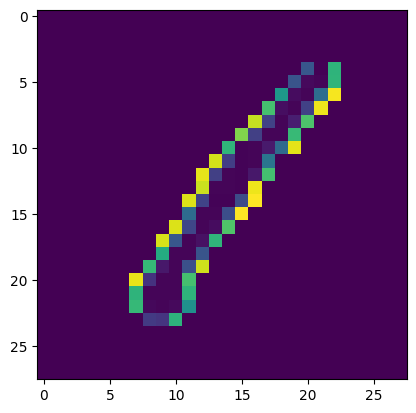

In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def show_image(image):
    to_pil = ToPILImage()
    image=image.float() 
    image_pil = to_pil(image)
    plt.imshow(image_pil)  
    plt.show()

train_image, train_label = next(iter(train_dataset))  
print("Train Label:", train_label) 
show_image(train_image)   

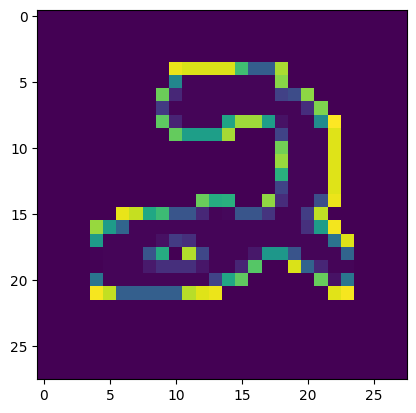

In [13]:
test_image = next(iter(test_dataset))  
show_image(test_image) 

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3, 3), stride=1, padding=0)
        self.b1=nn.BatchNorm2d(8)
        self.m1=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)
        self.layer2=nn.Conv2d(8,16,3,1,0)
        self.b2=nn.BatchNorm2d(16)
        self.layer3=nn.Conv2d(16,32,3,1,0)
        self.b3=nn.BatchNorm2d(32)
        self.layer4=nn.Conv2d(32,64,3,1,0)
        self.b4=nn.BatchNorm2d(64)
        self.flatten=nn.Flatten()
        self.layer5=nn.Linear(64*7*7,10)
        self.b5=nn.BatchNorm1d(10)
        self.r=nn.ReLU()

    def forward(self,x):
        x=self.layer1(x)
        x=self.b1(x)
        x=self.r(x)
        x=self.m1(x)
        x=self.layer2(x)
        x=self.b2(x)
        x=self.r(x)
        x=self.layer3(x)
        x=self.b3(x)
        x=self.r(x)
        x=self.layer4(x)
        x=self.b4(x)
        x=self.r(x)
        x=self.flatten(x)
        x=self.layer5(x)
        x=self.b5(x)
        
        return x

In [15]:
def trainmodel(model,train_dataloader,lossfunction,optimizer):
    model.train()
    correct=0
    totaloss=0
    for i, (img,label) in enumerate(train_dataloader):
        img=img.float().to(device)
        label=label.to(device)
        prediction=model(img)
        loss=lossfunction(prediction,label)
        totaloss+=loss.item()
        predictedvalue=torch.argmax(prediction,dim=1).type(torch.float)
        correct+=(predictedvalue==label).sum().item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batchloss=totaloss/(i+(img.shape[0]/batch_size))
        batchacc=(correct/((i*batch_size+img.shape[0])))*100
        batchloss=round(batchloss,2)#avg loss for batch
        batchacc=round(batchacc,2)
        if (i%200==0):
            print("For {0} batch the loss={1} and accuracy:{2}".format(i+1,batchloss,batchacc))
    epochloss=batchloss
    epochaccuracy=batchacc
#     epochloss=totaloss/len(train_dataloader) #avg loss for 1 batch
#     epochloss=round(epochloss,2)
#     totalimages=len(train_dataloader.dataset)
#     epochaccuracy=(correct/len(train_dataloader.dataset))*100 
#     epochaccuracy=round(epochaccuracy,2)
        
    return epochloss,epochaccuracy         

In [16]:
def testmodel(model,test_dataloader,lossfunction,path):
    model.eval()
    df=pd.read_csv(path)
    with torch.no_grad():
        for i, img in enumerate(test_dataloader):
            img=img.float().to(device)
            prediction=model(img)
            predictedvalue=torch.argmax(prediction,dim=1).type(torch.int).cpu()
#             predictedvalue=int(predictedvalue)
            start=i*batch_size
            end=start+batch_size
#             print(type(predictedvalue))
#             print(predictedvalue)
            df.iloc[start:end,1]=predictedvalue.numpy()
    df.to_csv('submission.csv', index=False)
    print(df.head(5))

In [17]:
#main code
model=CNN()
model=model.to(device)
lossfunction=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
epochs=20
path='/kaggle/input/digit-recognizer/sample_submission.csv'
for i in range(epochs):
    print("Epoch number: ",i+1)
    trainloss,trainacc=trainmodel(model,train,lossfunction,optimizer)
    print("Training epoch loss: ",trainloss,"Training accuracy: ",trainacc)
    print("\n")

Epoch number:  1
For 1 batch the loss=2.75 and accuracy:14.06
For 201 batch the loss=0.55 and accuracy:92.99
For 401 batch the loss=0.44 and accuracy:95.18
For 601 batch the loss=0.38 and accuracy:96.12
Training epoch loss:  0.36 Training accuracy:  96.32


Epoch number:  2
For 1 batch the loss=0.17 and accuracy:100.0
For 201 batch the loss=0.18 and accuracy:98.41
For 401 batch the loss=0.17 and accuracy:98.44
For 601 batch the loss=0.16 and accuracy:98.55
Training epoch loss:  0.15 Training accuracy:  98.58


Epoch number:  3
For 1 batch the loss=0.09 and accuracy:98.44
For 201 batch the loss=0.11 and accuracy:98.83
For 401 batch the loss=0.11 and accuracy:98.84
For 601 batch the loss=0.1 and accuracy:98.82
Training epoch loss:  0.1 Training accuracy:  98.83


Epoch number:  4
For 1 batch the loss=0.12 and accuracy:98.44
For 201 batch the loss=0.07 and accuracy:99.11
For 401 batch the loss=0.07 and accuracy:99.13
For 601 batch the loss=0.07 and accuracy:99.12
Training epoch loss:  0.0

In [18]:
testmodel(model,test,lossfunction,'/kaggle/input/digit-recognizer/sample_submission.csv')

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3


In [19]:
df=pd.read_csv('submission.csv')
df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
